In [47]:
import pandas as pd
from datetime import datetime
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import time
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
CSV_PATH='/home/kvassay/data/book-recommender/ratings_Books.csv'
QUESTIONS_PATH='/home/kvassay/data/book-recommender/questions.txt'
MODELS_FOLDER='/home/kvassay/data/book-recommender/models/'
%matplotlib inline

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)
logger.info('Logger works.') #to prevent duplicate logs

2016-12-14 08:00:17,174 - root - INFO - Logger works.


### Reading and sorting data

In [3]:
raw_data=pd.read_csv(CSV_PATH,header=0,names=['user','item','rating','timestamp'])

### Dumping data < 2013.

In [4]:
raw_data=raw_data[raw_data['timestamp']>1356998400]

### Extract user-item impressions dict

In [5]:
def split(raw_data, quantile=0.7):
    q=raw_data['timestamp'].quantile(quantile)
    return raw_data[raw_data['timestamp']<=q], raw_data[raw_data['timestamp']>q]

def get_user_items_dict(data, min_ratings, max_ratings):
    user_item_dict=dict()
    for row in data.itertuples():
        if row.user in user_item_dict:
            user_item_dict[row.user].append(row.item)
        else:
            user_item_dict[row.user]=[row.item]
    user_item_dict_clean={key: value for key,value in user_item_dict.iteritems() if len(value)>=min_ratings and len(value)<max_ratings}
    return user_item_dict_clean

def get_user_items_list_lengths(user_item_dict):
    return pd.DataFrame(sorted([len(item_list) for _,item_list in user_item_dict.iteritems()]))
    

def remove_users_not_in_train(train_dict, other_dict):
    #intersection=set(other_dict.keys()) & set(train_dict.keys())
    #n_intersection=len(intersection)
    #new_dict={key: other_dict[key] for key in intersection}
    #len_before=len(other_dict)
    #n_removed = len_before - len(new_dict)
    #logger.info('Removed %s users which weren\'t in the training set. Intersection cardinality: %s...', n_removed, n_intersection)
    keys=other_dict.keys()
    for key in keys:
        if not key in train_dict:
            del other_dict[key]
    return other_dict

### Train-test split

In [6]:
raw_train, raw_test = split(raw_data)
raw_train, raw_dev = split(raw_train)

In [7]:
user_item_train = get_user_items_dict(raw_train, min_ratings=10, max_ratings=100)
user_item_dev = get_user_items_dict(raw_dev, min_ratings=2, max_ratings=1000000)
user_item_test = get_user_items_dict(raw_test, min_ratings=2, max_ratings=1000000)

user_item_dev=remove_users_not_in_train(user_item_train, user_item_dev)
user_item_test= remove_users_not_in_train(user_item_train, user_item_test)

### Training dataset Analysis

#### User count

In [8]:
len(user_item_train.keys())

62105

#### Item count distribution per user

In [9]:
item_counts_train=get_user_items_list_lengths(user_item_train)
item_counts_dev=get_user_items_list_lengths(user_item_dev)
item_counts_test=get_user_items_list_lengths(user_item_test)

In [10]:
item_counts_train.describe()

,0
count,62105.000000
mean,20.078190
std,14.454616
min,10.000000
25%,11.000000
50%,15.000000
75%,22.000000
max,99.000000


In [11]:
item_counts_dev.describe()

,0
count,35702.000000
mean,9.754159
std,12.897457
min,2.000000
25%,3.000000
50%,6.000000
75%,12.000000
max,511.000000


In [12]:
item_counts_test.describe()

,0
count,35656.000000
mean,11.585708
std,16.979665
min,2.000000
25%,3.000000
50%,6.000000
75%,13.000000
max,660.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5302923610>]], dtype=object)

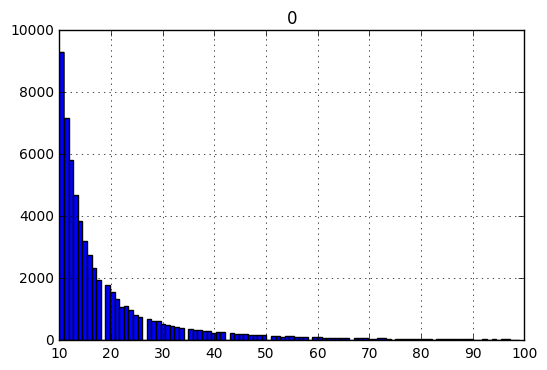

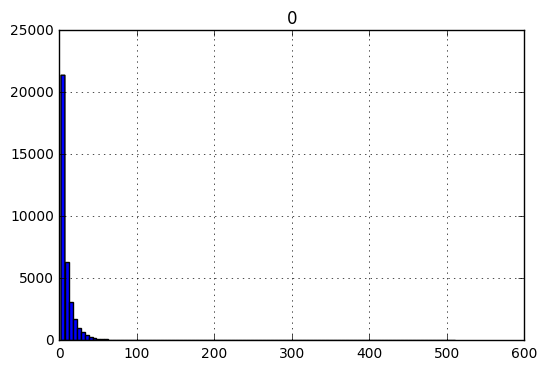

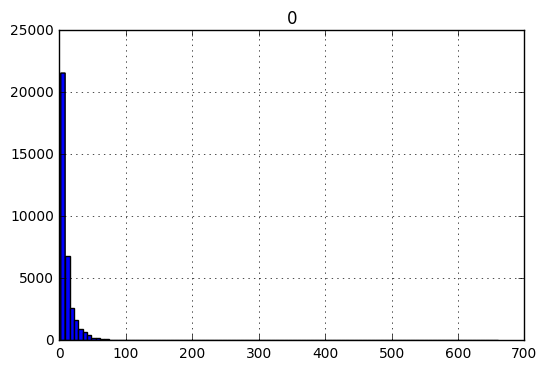

In [13]:
nbins=100
item_counts_train.hist(bins=nbins)
item_counts_dev.hist(bins=nbins)
item_counts_test.hist(bins=nbins)

### Limiting dataset sizes

Especially evaluations take a lot of time, limiting dataset sizes might be useful.

In [14]:
#for testing:
TRAIN_SIZE=100000
DEV_SIZE=1000
TEST_SIZE=1000
'''
In addition to limiting the dataset sizes we need to make sure, 
that all users from DEV and TEST set are present in TRAIN set.
To do that we simply add them to TRAIN set after limiting.
'''
user_item_train_tmp={key: user_item_train[key] for key in user_item_dev.keys()[:TRAIN_SIZE]}
user_item_dev={key: user_item_dev[key] for key in user_item_dev.keys()[:DEV_SIZE]}
user_item_test={key: user_item_test[key] for key in user_item_test.keys()[:TEST_SIZE]}
for usr in user_item_dev:
    if usr not in user_item_train_tmp:
        user_item_train_tmp[usr]=user_item_train[usr]
for usr in user_item_test:
    if usr not in user_item_train_tmp:
        user_item_train_tmp[usr]=user_item_train[usr]
user_item_train=user_item_train_tmp
len(user_item_train)

35925

### Training data preparation
For Gensim

In [15]:
train_data=[TaggedDocument([unicode(word) for word in words], [user_id]) for user_id, words in user_item_train.iteritems()]
dev_data=[TaggedDocument([unicode(word) for word in words], [user_id]) for user_id, words in user_item_dev.iteritems()]


### Baseline model and evaluation function
Evaluation methods and Baseline model for comparison.

In [41]:
class BaselineModel():
    '''
    Always returns k most frequent items.
    '''
    def __init__(self,train_set,topn=10):
        logger.info('Couting %s most frequent items for BaselineModel...',topn)
        items=list()
        for key in train_set:
            items.extend(train_set[key])
        counter=Counter(items)
        self.result=counter.most_common(10)
        logger.info('BaselineModel initialized...')
        
    def most_similar(self, positive=None, topn=None):
        #parameters are there just for compatibility with Gensim model evaluator
        return self.result
        
        
def percentage(part, whole):
    return 100 * float(part)/float(whole)

def evaluate_score(model, train_set, test_set,topn=10, limit_users=None):
    '''
    Asks model for k recommendations based on users data in the past (train_set)
    and looks if at least one of them appeared in the future (test_set). In the end
    evaluator returns in how many % cases it did.
    '''
    rec_count=0
    confirmed_match=0
    if limit_users is not None:
        users=test_set.keys()[:limit_users]
        np.random.shuffle(users)
    else:
        users=test_set.keys()
    for user in users:
        train_items=train_set[user]
        test_data=test_set[user]
        
        result=[tupl[0] for tupl in model.most_similar(positive=train_items, topn=topn)]
        for item in result:
            if item in test_data:
                confirmed_match+=1
                break
        rec_count+=1
    return percentage(confirmed_match,rec_count)
    
    

### Doc2Vec models training

In [39]:
'''
Initializing model
'''
logger.info('Initializing model...')
model = Doc2Vec(alpha=0.025, min_alpha=0.025, min_count=1, size=300, window=8, negative=2)  # use fixed learning rate
logger.info('Building vocabulary...')
logger.setLevel(logging.ERROR)
start=time.time()
model.build_vocab(train_data)
dur=time.time()-start
logger.setLevel(logging.INFO)
logger.info('Building vocabulary took %s seconds...', dur)
'''
Learning model for multiple epochs, after each model is persisted to HDD.
'''
for epoch in range(1,20,1):
    start=time.time()
    logger.info('Shuffling training data')
    '''
    Data are shuffled before each iteration to ensure ordering 
    won't corrupt gradient computation and not cause overfitting on some local minima
    '''
    np.random.shuffle(train_data)
    dur=time.time()-start
    logger.info('Shuffling training set took %s seconds...', dur)
    start=time.time()
    model_save_path=MODELS_FOLDER+'doc2vec_model_ep'+str(epoch)
    logger.info('Training epoch no. %s...',epoch)
    logger.setLevel(logging.ERROR)
    '''
    Training
    '''
    model.train(train_data)
    '''
    Persisting
    '''
    model.save(model_save_path)
    model.alpha -= 0.0005  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay
    logger.setLevel(logging.INFO)
    dur=time.time()-start
    logger.info('Training model and persisting took %s seconds...', dur)

KeyboardInterrupt: 

### Doc2Vec model evaluation

In [43]:

logger.setLevel(logging.INFO)
baseline_model=BaselineModel(user_item_train)
model_paths=[MODELS_FOLDER+'doc2vec_model_ep'+str(r) for r in range(1,20,1)]
logger.info('Computing scores...')
scores=list()
scores_baseline=[evaluate_score(baseline_model, user_item_train, user_item_dev)]*len(model_paths)
logger.info('Baseline score: %s%%...',scores_baseline[0])
for i in xrange(len(model_paths)):
    start=time.time()
    logger.info('Loading model no. %s...',i+1)
    logger.setLevel(logging.ERROR)
    model=Doc2Vec.load(model_paths[i])
    dur=time.time()-start
    logger.setLevel(logging.INFO)
    logger.info('Model loading took %s seconds...', dur)

    logger.info('Computing score for epoch %s...',i+1)
    logger.setLevel(logging.ERROR)
    start=time.time()
    score=evaluate_score(model, user_item_train, user_item_dev)
    dur=time.time()-start
    logger.setLevel(logging.INFO)
    logger.info('Computing score took %s seconds...', dur)
    logger.info('Score for epoch %s = %s %%...',i+1,score)
    scores.append(score)
logger.info('Result scores: %s', scores)
    

2016-12-14 08:31:41,202 - root - INFO - Couting 10 most frequent items for BaselineModel...
2016-12-14 08:31:41,707 - root - INFO - BaselineModel initialized...
2016-12-14 08:31:41,723 - root - INFO - Computing scores...
2016-12-14 08:31:41,730 - root - INFO - Baseline score: 1.2%...
2016-12-14 08:31:41,732 - root - INFO - Loading model no. 1...
2016-12-14 08:31:44,055 - root - INFO - Model loading took 2.32280993462 seconds...
2016-12-14 08:31:44,055 - root - INFO - Computing score for epoch 1...
2016-12-14 08:32:00,603 - root - INFO - Computing score took 16.547219038 seconds...
2016-12-14 08:32:00,604 - root - INFO - Score for epoch 1 = 3.7 %...
2016-12-14 08:32:00,619 - root - INFO - Loading model no. 2...
2016-12-14 08:32:06,910 - root - INFO - Model loading took 6.29181313515 seconds...
2016-12-14 08:32:06,912 - root - INFO - Computing score for epoch 2...
2016-12-14 08:32:29,390 - root - INFO - Computing score took 22.4758551121 seconds...
2016-12-14 08:32:29,391 - root - INFO -

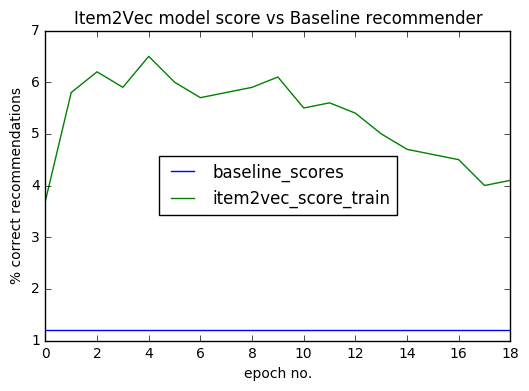

In [52]:
df=pd.DataFrame.from_dict({'item2vec_score_train': scores,'baseline_scores':scores_baseline})
df.plot()
plt.title('Item2Vec model score vs Baseline recommender')
plt.xlabel('epoch no.')
plt.ylabel('% correct recommendations')